### Importing the libararies

In [1]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# For data cleaning
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.impute import KNNImputer

# For encoding the data
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ys723\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ys723\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Reading the data from csv file
df = pd.read_csv('dataset.csv')

### Introductory EDA

1. Does fraud job posting have company logo ?
2. Is there some specific location where fraud job postings are maximum ? 
3. What benifits does fraud companies offer ?
4. What is the salary range of fraud job posting ?
5. Most Fraud job posting belong to which specific industry and department ?
6. How much experience does fraud job posting demands ?
7. Fraud job posting offer which employment type

In [3]:
# Checking the shape of dataset
print('Shape of dataframe :',df.shape)

Shape of dataframe : (17880, 18)


In [4]:
# CHecking any some random rows from the dataset
df.sample(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
5412,5413,Senior Full-Stack Developer,"IL, TA, Tel Aviv",R&D,NaN,The only thing we love more than our data is o...,As a senior full-stack developer in a new exci...,Skills &amp; Requirements5 years’ experience i...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
463,464,Finance,"GB, , London",NaN,NaN,We believe cities are complicated. And your mo...,"Strategic analysis around product, cities expa...",NaN,NaN,0,1,1,Full-time,NaN,Bachelor's Degree,NaN,NaN,0
5294,5295,CRM Manager,"MT, ,",CustomerSupport,NaN,NaN,On behalf of our client we are looking for a C...,Your responsibilities will include:Working clo...,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,0


- From the very first look at the dataset, I feel that job_id will not make any sense to detect whether a job posting is genuine or fraud, so for that we will simply remove this column from the dataframe.
- The target variable only have 2 labels so this is binary classification problem

In [5]:
# Dropping unnecessary column from dataframe
df.drop(['job_id'],axis=1,inplace=True)

In [6]:
# Let's get some basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

- There are some missing values in the dataset
- For storing the numerical data instead of using the float64 or int64 we can use the int32 or float32 datatype to reduce the memory usage.

In [7]:
# Changing the datatype to reduce the memory usage
int_cols = df.select_dtypes(include = np.int64)
float_cols = df.select_dtypes(include = np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

- Before memory usage : 2.3 mb
- After memory usage : 2.0 mb

In [8]:
# Let's get a descriptive summary of our dataset
df.describe()

,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [9]:
# Let's check if there are any duplicate values
print("Total duplicate values :",df.duplicated().sum())

Total duplicate values : 281


In [10]:
# Let's check if there are any missing values
df.isnull().mean()*100

title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.072707
benefits               40.324385
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64

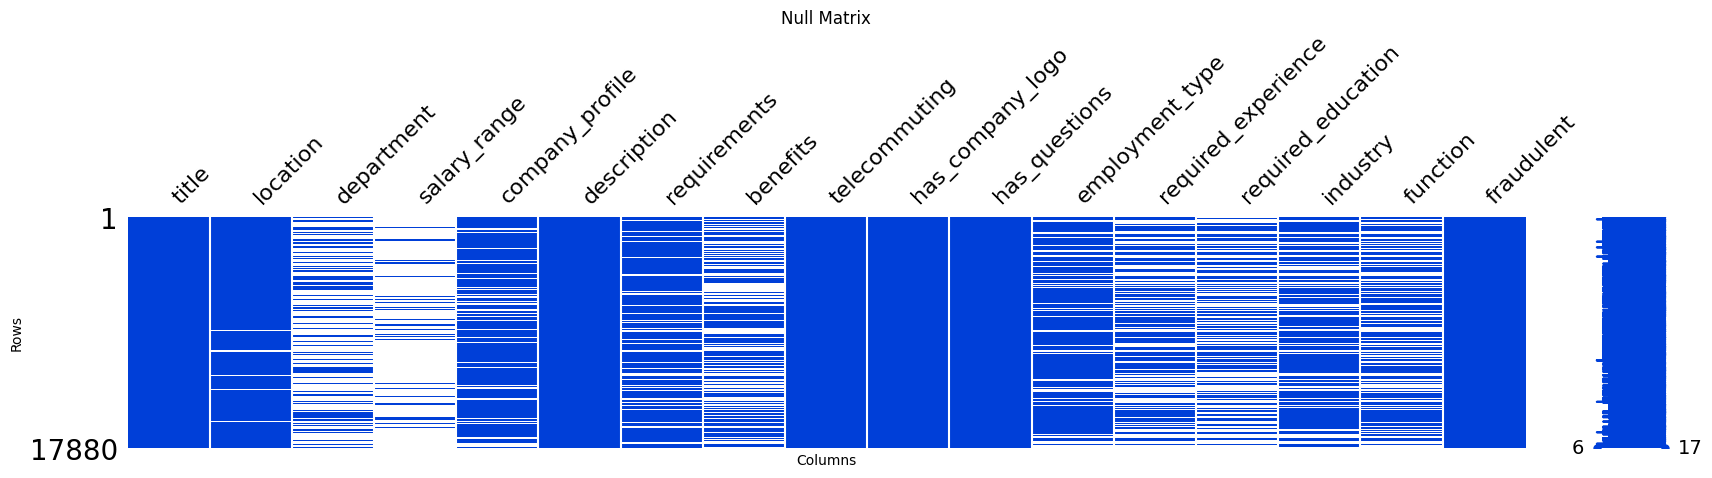

In [11]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df,figsize=(20, 3),color=(0, 0.25, 0.85))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

Generally when the percentage of missing value in some column is more than 50% it it recommended to drop that column, but let's use another way. Instead of dropping the salary range and ignoring it completely let us create a new binary feature which will have 0 and 1 value representing that whether salary range is given or not.

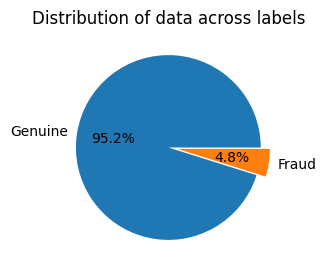

In [12]:
# Let's check the distribution of data across labels 0 -> Genuine and 1 -> Fraud
fig,ax = plt.subplots(figsize = (3,3))

ex = [0.0,0.1]
plt.pie(df['fraudulent'].value_counts(), labels=['Genuine', 'Fraud'],autopct='%1.1f%%',explode = ex)
plt.title("Distribution of data across labels")
plt.show()

### Data cleaning and Processing

- Dealing with missing values
- Dealing with outliers
- Encoding categorical values
- Cretion of embeddings

In [13]:
salary_range_present = []

for i in range(len(df['salary_range'])):
    if pd.isna(df['salary_range'].iloc[i]):
        salary_range_present.append(0)  # Salary range not provided
    else:
        salary_range_present.append(1) # Salary range provided

df['Salary_range_provided'] = salary_range_present
df.drop(['salary_range'],inplace=True,axis=1)

Just like for salary_range feature we will do the same thing for the department feature.

In [14]:
department_mentioned = []
for i in range(len(df['department'])):
    if pd.isna(df['department'].iloc[i]):
        department_mentioned.append(0) # Department not provided
    else:
        department_mentioned.append(1) # Department mentioned

df['department_mentioned'] = department_mentioned
df.drop(['department'],inplace=True,axis=1)

In [15]:
# Let's impute the missing values in the location feature using the mode imputation
df['location'].fillna(df['location'].mode()[0],inplace=True)

**Important note**

Out of all the features having missing values *employment_type,required_experience,industry,function* are 4 features for which we can use the KNN imputer algorithm for imputing the missing values. But before using KNN imputer we need to make sure that our data is useful for KNN imputer algorithm to work properly. In simple words we need to make sure that the data which we will be using should be properly encoded and free form any outliers.

Now since most of the features in our dataset are textual features so instead of considering the entire dataset we will take subset of data, encode the categorical features and then we will use KNN imputer algorithm. Subset of data will contain *'telecommuting', 'has_company_logo', 'has_questions','employment_type', 'required_experience', 'required_education','industry', 'function', 'fraudulent', 'Salary_range_provided'* features.

In [16]:
subset_data_cols = ['telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'Salary_range_provided']

# Subset of data for KNN imputer
Subset_df = df[subset_data_cols].copy()

# Instantiating Ordinal encoder class
oe_exp = OrdinalEncoder(categories = [['Not Applicable','Internship','Entry level','Mid-Senior level','Associate','Director','Executive']],
                        handle_unknown='use_encoded_value',unknown_value=np.nan)

oe_edu = OrdinalEncoder(categories = [["Unspecified", "Some High School Coursework", "High School or equivalent", "Some College Coursework Completed", "Vocational",
     "Vocational - HS Diploma", "Vocational - Degree", "Associate Degree", "Certification", "Professional", "Bachelor's Degree", "Master's Degree", "Doctorate"]],
                   handle_unknown='use_encoded_value',unknown_value=np.nan)      

# Instantiating the target encoder class
te_emp_type = ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan',return_df=False)
te_industry = ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan',return_df=False)
te_function = ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan',return_df=False)

In [17]:
Subset_df['required_experience'] = pd.Series(oe_exp.fit_transform(Subset_df['required_experience'].values.reshape(-1,1)).reshape(-1))
Subset_df['required_education'] = pd.Series(oe_edu.fit_transform(Subset_df['required_education'].values.reshape(-1,1)).reshape(-1))


y = Subset_df['fraudulent'].values.reshape(-1,1)
Subset_df['employment_type'] = pd.Series(te_emp_type.fit_transform(Subset_df['employment_type'].values.reshape(-1,1),y).reshape(-1))
Subset_df['industry'] = pd.Series(te_industry.fit_transform(Subset_df['industry'].values.reshape(-1,1),y).reshape(-1))
Subset_df['function'] = pd.Series(te_function.fit_transform(Subset_df['function'].values.reshape(-1,1),y).reshape(-1))

In [18]:
knn_imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')

Subset_df = knn_imputer.fit_transform(Subset_df)
Subset_df = pd.DataFrame(Subset_df,columns = subset_data_cols)

In [19]:
df.drop(subset_data_cols,inplace=True,axis=1)

df.reset_index(drop=True,inplace=True)
Subset_df.reset_index(drop=True,inplace=True)

# Concatinating the dataframes
df = pd.concat([df,Subset_df],axis=1,ignore_index=False)

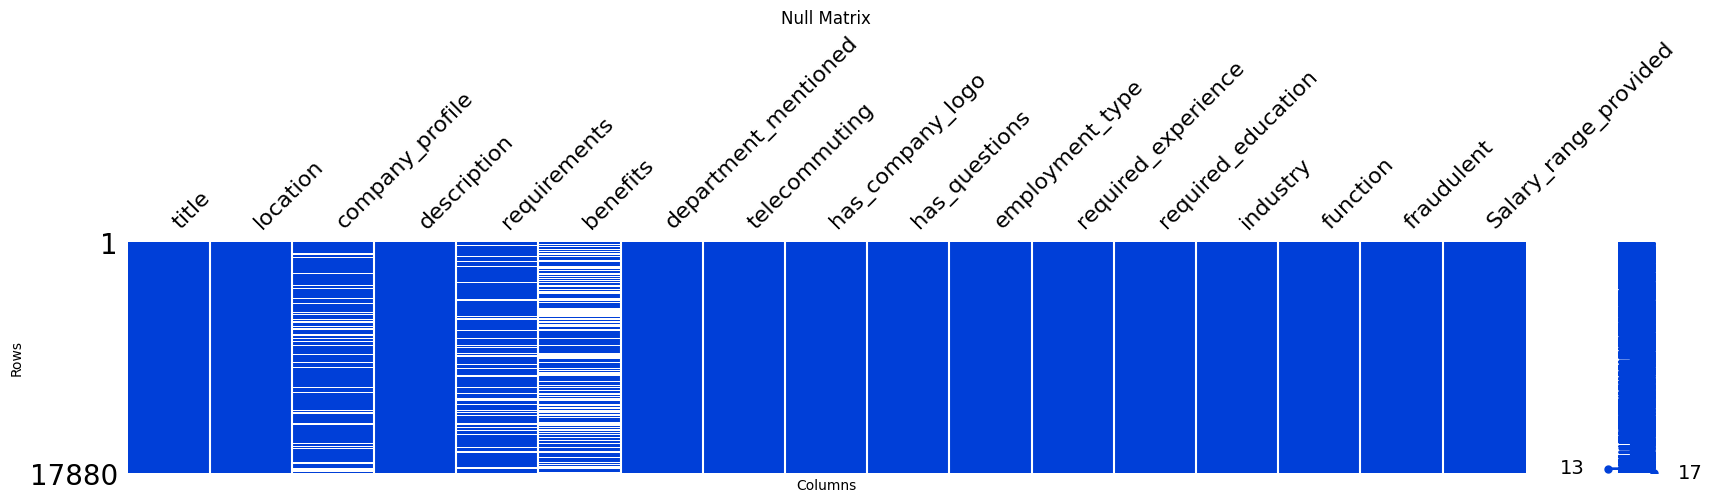

In [20]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df,figsize=(20, 3),color=(0, 0.25, 0.85))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

Latent Dirichlet allocation (LDA): This is a statistical technique that can be used to impute missing values in textual data. LDA works by assuming that the text is generated by a mixture of topics, and then uses this information to impute the missing values.

**Important Note**

Instead of removing missing values in text data, we can also impute them with the word "missing" as a sort of flag. This will allow us to keep the data intact, while still being aware of the missing values.

There are a few advantages to this approach. First, it allows us to use the data for training machine learning models, even if there are some missing values. Second, it allows us to track the number of missing values in the data, which can be helpful for understanding the quality of the data.

In [21]:
# Impting the missing values with Missing word
for cols in ['company_profile','requirements','benefits','description']:
    df[cols].fillna('Missing',inplace=True)

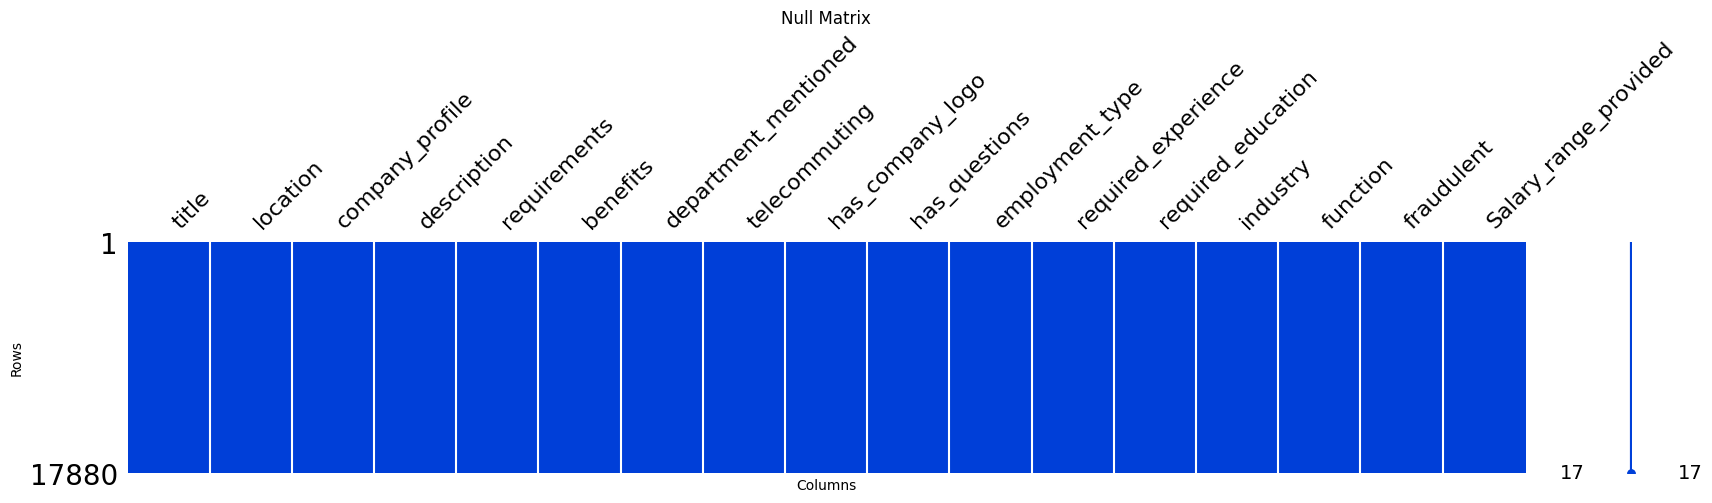

In [22]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df,figsize=(20, 3),color=(0, 0.25, 0.85))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

In [23]:
class clean_data:
    lemm = nltk.WordNetLemmatizer()
    stop_words = nltk.corpus.stopwords.words('english')
    punctuations = string.punctuation

    def remove_punctuations(self, text: str) -> str:
        return ''.join(char for char in text if char not in self.punctuations)

    def remove_stopwords(self, text: str) -> str:
        return ' '.join(word for word in text.split() if word not in self.stop_words)

    def lemmatize(self, text: str) -> str:
        return ' '.join(self.lemm.lemmatize(word) for word in text.split())

In [24]:
# Instantiate the clean_data class
cd = clean_data()

# Apply the clean_data methods to the text columns in your DataFrame
text_cols = ['company_profile', 'description', 'requirements','benefits']

for col in text_cols:
    df[col] = df[col].apply(cd.remove_punctuations)
    df[col] = df[col].apply(cd.remove_stopwords)
    df[col] = df[col].apply(cd.lemmatize)

In [26]:
df.head(4)

,title,location,company_profile,description,requirements,benefits,department_mentioned,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Salary_range_provided
0,Marketing Intern,"US, NY, New York",Were Food52 weve created groundbreaking awardw...,Food52 fastgrowing James Beard Awardwinning on...,Experience content management system major plu...,Missing,1,0.0,1.0,0.0,0.066079,1.0,8.6,0.017345,0.012048,0.0,0.0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",90 Seconds world Cloud Video Production Servic...,Organised Focused Vibrant AwesomeDo passion cu...,What expect youYour key responsibility communi...,What get usThrough part 90 Seconds team gainex...,1,0.0,1.0,0.0,0.042169,0.0,5.2,0.054348,0.054516,0.0,0.0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions me...,Our client located Houston actively seeking ex...,Implement precommissioning commissioning proce...,Missing,0,0.0,1.0,0.0,0.042169,3.0,10.0,0.015199,0.037155,0.0,0.0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion improving quality life geography h...,THE COMPANY ESRI – Environmental Systems Resea...,EDUCATION Bachelor’s Master’s GIS business adm...,Our culture anything corporate—we collaborativ...,1,0.0,1.0,0.0,0.042169,3.0,10.0,0.003634,0.027929,0.0,0.0


### Feature engineering